<a href="https://colab.research.google.com/github/adasegroup/ML2023_seminars/blob/master/seminar2/Seminar_2_regression-solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Content :

In this seminar we cover different aspects of the one of two main problem statements in machine learning: a regression problem!

In particular we consider:

1. Parameter estimation for real & noisy observations
2. How to choose right estimates: - regression model quality metrics
3. Regulariation: LASSO and Ridge regressions 
4. Kernel regression
5. Overfitting for regression

# Regression problem statement

We consider a sample of pairs $D = {(\mathbf{x}_i, y_i)}_{i = 1}^N$. Input features $\mathbf{x}_i \in \mathbb{R}^d$, output $y_i \in \mathbb{R}$. 

The goal is to construct a regression model $\hat{y}(\mathbf{x}_i)$ that predicts the output using input features:
$$
\hat{y}(\mathbf{x}_i) \approx y_i.
$$




In [1]:
# required imports

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

font = {'size'   : 20}
plt.rc('font', **font)
label_font_size = 18
legend_font_size = 18

np.random.seed(4242)

# 1. Estimating from real & noisy observations.

## A simple linear case with noise.  

In this example, we have data collected from some device. We try to measure $v_0$ and $a$ in the following equation:

$$ v = v(x) = v_0 + a x, \  x \in [20, 120]$$
But our device is not perfect and has some measurement error, some of the values contain noise, so let's assume that the coefficients are random variables: 
$$ a \sim  \mathcal{N}(3, 1), \   v_0 \sim \mathcal{N}(7, 5) $$

Our goal is to **build an accurate predictive model** as a function $\hat{v}(x)$ regardless the measurement error.

In [2]:
# set the parameters with respect to the problem statement
points = np.arange(20, 120)

v0_real = 7
a_real = 3
v_real = v0_real + a_real * points # observations without noise

a = np.random.normal(loc=a_real, scale=1, size=points.shape)
v0 = np.random.normal(loc=v0_real, scale=5, size=points.shape)

v = v0 + a * points # observations with noise

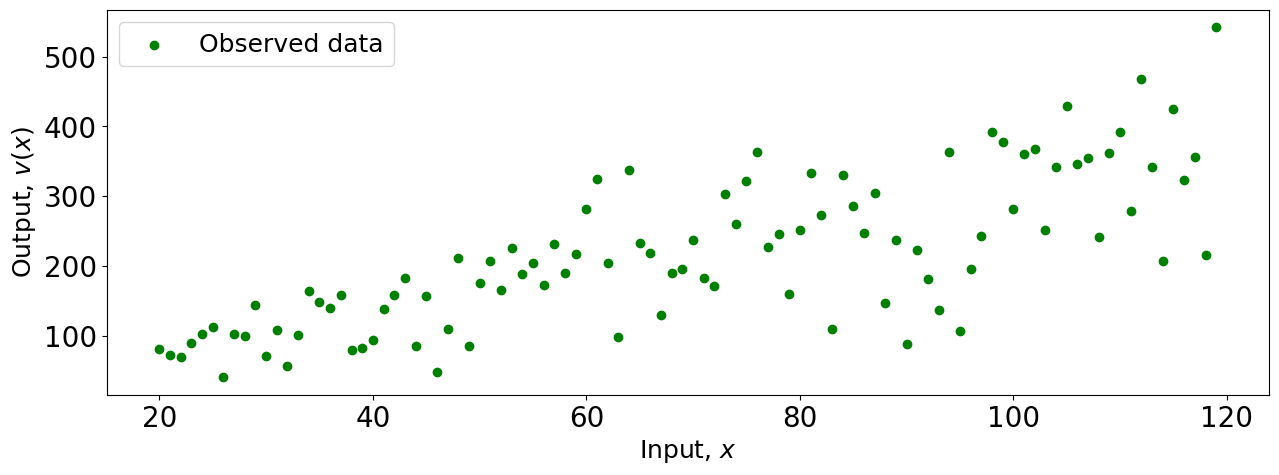

In [4]:
plt.figure(figsize=(15, 5))
plt.xlabel('Input, $x$', fontsize=label_font_size)
plt.ylabel('Output, $v(x)$', fontsize=label_font_size)

plt.scatter(points, v, label='Observed data', color='g')
plt.legend(fontsize=legend_font_size);

- We need to solve a regression problem: recover or approximate $v_0$ and $a$ from given observations. <br>
- With two parameters $v_0$ and $a$ we can plot a line which will be our estimate. 

- What is the best line? And how to choose the best line? Since  $v_0$ and $a$ can take an infinite number of values, we have an infinite number of lines / an infinite number of functions $v(x) = v_0 + a x$. 

 # 2. How to choose right estimates: regression quality metrics

**How to choose the right parameters? What line is better?**

$\hat{v}$ is our estimation here with parameters plugged manually from manual inspection of the plots. 
From now let's pretend we do not know true values of $a$ and $v_0$.

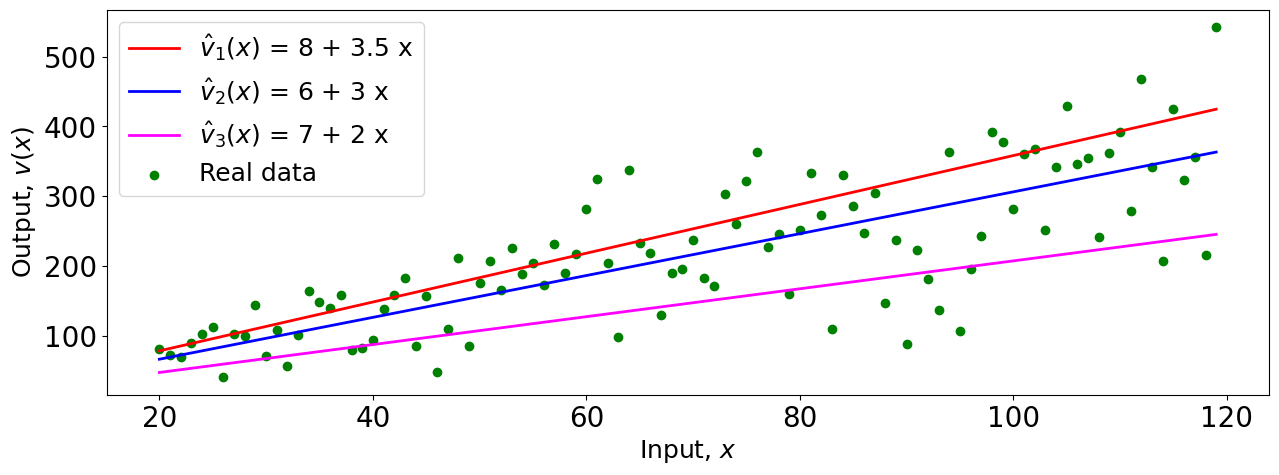

In [5]:
plt.figure(figsize=(15, 5))
plt.xlabel('Input, $x$', fontsize=label_font_size)
plt.ylabel('Output, $v(x)$', fontsize=label_font_size)

v_estimate_one = 8 + 3.5 * points
v_estimate_two = 6 + 3 * points
v_estimate_three = 7 + 2 * points

plt.plot(points, v_estimate_one, label='$\hat{v}_1(x)$ = 8 + 3.5 x ', color='r', lw=2);
plt.plot(points, v_estimate_two, label='$\hat{v}_2(x)$ = 6 + 3 x', color='b', lw=2);
plt.plot(points, v_estimate_three, label='$\hat{v}_3(x)$ = 7 + 2 x', color='magenta', lw=2);
plt.scatter(points, v, label='Real data', color='g')
plt.legend(fontsize=legend_font_size);

To find the best fit, we measure distances from estimated lines to the true points and choose one with the smallest average distance or one with the smallest average squared distance. 

$N$ - number of observations. <br>
$y_i$ - real (true) data points. <br>
$\hat{f}$ - our predictions <br>

Here is the most popular distances for regression task Mean Squared Error (MSE), Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE):
$$
MSE(\hat{f}, D) = \frac{1}{N} \sum_{i=1}^{N}\left(\ y_i - \hat{f}(x_i)\ \right) ^2,
$$

$$
MAE(\hat{f}, D) = \frac{1}{N} \sum_{i=1}^{N}\left|\ y_i - \hat{f}(x_i)\ \right|,
$$

$$
MAPE (\hat{f}, D) = \frac{100}{N} \sum_{i=1}^{N}\left| \frac{y_i - \hat{f}(x_i)}{y_i} \right|.
$$


For now let's use $MSE$. In our case real or observed values are $v(x_i)$ and $\hat{v}(x_i)$ is our model's predictions with some parameters $a$ and $v_0$.

$$ 
MSE(v, \hat{v}) = \frac{1}N \sum_{i = 1}^{N} (v(x_i) - \hat{v}(x_i))^2. 
$$

### Let's illustrate how $MSE$ looks like

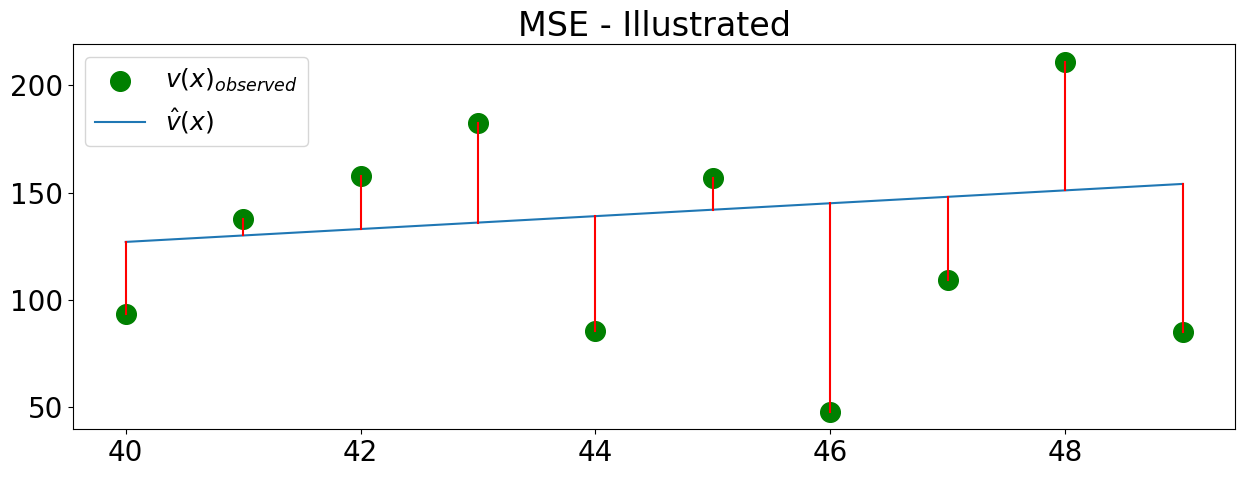

In [6]:
plt.figure(figsize=(15, 5))
plt.scatter(points[20:30], v[20:30], s=200, c='g', alpha=1, label='$v(x)_{observed}$')
plt.plot(points[20:30], v_real[20:30], label='$\hat{v}(x)$')

#plt.scatter(t[20:30], v[20:30], s=200, c='b', label='y')

for _point, _v in zip(points[20:30], v[20:30]):
    plt.plot([_point, _point], [_v, a_real * _point + v0_real], c='r')

plt.title("MSE - Illustrated")
plt.legend(fontsize=legend_font_size);

Let's try to estimate our parameters $v_0$ and $a$ naively by "eye" and see what error we get (let's pretend we do not know their real values). 

But to estimate the parameters we need to implement this function first $MSE(v,\hat{v})= \frac{1}N \sum_i^{N} (v(t_i) - \hat{v}(t_i))^2 $.

In [7]:
# Your task: implement MSE function 

def mse(v_true, v_pred):
    # v_true - a vector of true values
    # v_pred - a vector of predictions

    return #MSE (single value)

In [19]:
# SOLUTION

def mse(v_true, v_pred, prec=2):
    return np.round(np.mean((v_true - v_pred)**2), prec)

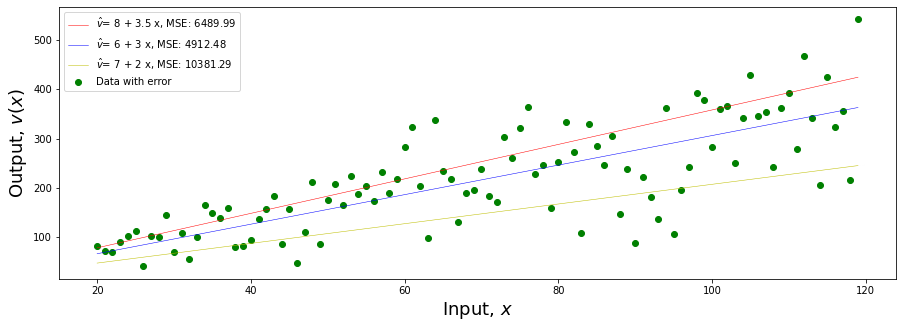

In [ ]:
plt.figure(figsize=(15, 5))
plt.xlabel('Input, $x$', fontsize=label_font_size)
plt.ylabel('Output, $v(x)$', fontsize=label_font_size)

v_estimate_one = 8 + 3.5 * points
v_estimate_two = 6 + 3 * points
v_estimate_three = 7 + 2 * points
plt.plot(points, v_estimate_one, label="$\hat{v}$" + f"= 8 + 3.5 x, MSE: {mse(v, v_estimate_one)}", color='r', lw=0.5);
plt.plot(points, v_estimate_two, label="$\hat{v}$" + f"= 6 + 3 x, MSE: {mse(v, v_estimate_two)}", color='b', lw=0.5);
plt.plot(points, v_estimate_three, label="$\hat{v}$" + f"= 7 + 2 x, MSE: {mse(v, v_estimate_three)}", color='y', lw=0.5);
#plt.plot(points, y_real, label='real', color='r', lw=0.5);
plt.scatter(points, v, label='Data with error', color='g')
plt.legend();

In this toy example it was easy to find the right coefficients.  For multdimensional input it is impossible, as the search space is large. <br>
Let's try to find more accurate coefficients and compute them. We need to choose such parameters $v_0$ and $a$ such that our MSE value is as small as possible for a test sample

We will be more formal from now on and define:
$$\hat{v}(x) = v_0 + a x =  \hat{f}(x) = a x + b$$


1. We have $X$ and $\mathbf{y}$: $\{(\mathbf{x}_1, y_1), (\mathbf{x}_2, y_2), \ldots, (\mathbf{x}_n, y_n)\}$, $X = (\mathbf{x}_1, \ldots, \mathbf{x}_n)$, $ \mathbf{y}= (y_1, \ldots, y_n)$.
2. And we want to find $\hat{f}(\mathbf{x})$ to minimize 
$$MSE(\hat{f}, D) = \frac{1}{N} \sum_{i=1}^{N}\left(\ y_i - \hat{f}(\mathbf{x}_i)\ \right) ^ 2 \rightarrow \text{min}$$
3. We assume that $\hat{f}(x)$ is linear:
$$\hat{f}(x) = ax + b.$$

----
Now we plug  $\hat{f}(x)$ in MSE and get:
$$
\frac{1}{N} \sum_{i=1}^{N}\left(\ y_i - ax_i - b\right) ^ 2 \rightarrow \text{min}_{a, b}.
$$

There are two options to find $a$ and $b$:
1. Analytically in vector form: take the first derivative, find parameters that lead to zero value of the first derivative.
2. Find partial derivatives with respect to $a$ and $b$ and apply a gradient descent.


We will set $X$ as an array with observed values in the second column and ones in the first, so $X$ has shape $N$ x $2$, where $N$ is the number of observations.
Then we will write our parameters $a$ and $b$ as a vector $\theta = [b, a]$, then we have:

$$
\hat{f}(x) = ax + b.
$$

For the whole sample we have:

$$
\hat{f}(X) = X \theta. 
$$

After we plug this vectorised form into MSE we get:

$$
\frac{1}{N}(\mathbf{y} - X \theta)^{T} (\mathbf{y} - X \theta) \rightarrow min_{\theta}
$$
Take the derivative with respect to  $\theta$ and make it equal to 0:
$$
\mathbf{y} = X \theta
$$
because $X$ is  not squared and can't be invered, we  multiply both sides on $X^T$
$$
X^T \mathbf{y} = X^T X \theta
$$
matrix $X^T X$ is almost always invertible, therefore we can compute $\theta$:
$$
\hat{\theta} = (X^T X)^{-1} X^T \mathbf{y}
$$
Again, first we compute $\theta = (X^T X)^{-1} X^T \mathbf{y}$, then we can use it to estimate $\hat{f}(X) = X \theta $. Note, that in vector form $\theta = [b,a]$ and one dimention (column) of $X$ should have all 1, that will serve as a multiplier coefficient in front of $b$.

Now your task is to implement a function which computes $\theta$ .

(This equation for $\theta$ is called **Normal equation**)

In [ ]:
# YOUR TASK IS TO COMPUTE THETA

def compute_theta(X, y):
    # X is a vector of values
    # y is a vector of values

    # EXPAND OUR X WITH ONES FOR BIAS TERM
    x_with_ones = np.ones(shape = (X.shape[0], 2))
    x_with_ones[:, 1] = X

    # COMPUTE THETA TIPS:
    # np.linalg.inv(matrix) - use to compute inverse of a matrix
    # np.dot(matrix_one, matrix_two) - use for matrix multiplication

    # theta = 
    return theta

In [8]:
# SOLUTION

def compute_theta(X, y):
    # EXPAND OUR X WITH ONES FOR BIAS TERM
    x_with_ones = np.ones(shape = (X.shape[0], 2))
    x_with_ones[:, 1] = X
    theta = np.linalg.inv((x_with_ones.T.dot(x_with_ones))).dot(x_with_ones.T).dot(y)
    return theta

Now we compute our estimates for $\theta$:

In [9]:
print(compute_theta(points, v))
b, a = list(compute_theta(points, v))

[21.40493889  2.80629523]


We can see that we have got quite bad estimates for $v_0$ and not bad values for $a$ but let's plot them anyway

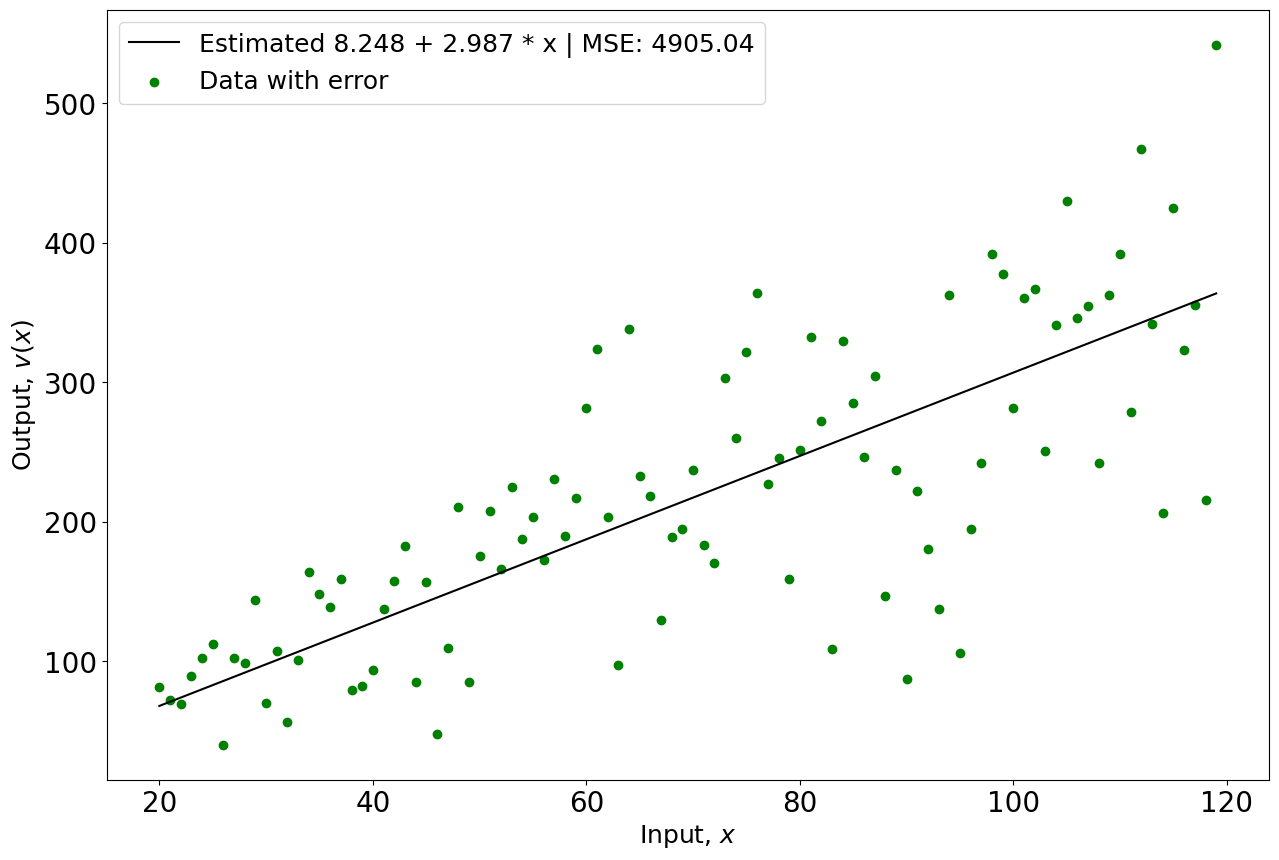

In [22]:
plt.figure(figsize=(15, 10))

plt.xlabel('Input, $x$', fontsize=label_font_size)
plt.ylabel('Output, $v(x)$', fontsize=label_font_size)

v_estimate = b + a * points
plt.plot(points, v_estimate, label=f"Estimated {round(b, 3)} + {round(a, 3)} * x | MSE: {mse(v, v_estimate)}", color='k', lw=1.5);
plt.scatter(points, v, label='Data with error', color='g')
plt.legend(fontsize=legend_font_size);

Remember that $a$ and $v_0$ have the following distributions: 

$$ a \sim  \mathcal{N}(3, 1), \   v_0 \sim \mathcal{N}(7, 5) $$

We have got not bad results for $a$. <br>

Why results for $v_0$ are much worse? Your ideas?


Also, we can see that is still better than our naive approach "plugging values on the eye". However, in real life we have only a small subset of data. Let's see if we can do well only with a half of our observations

In [23]:
training_points_number = 50

training_points = np.random.choice(points.shape[0], training_points_number,  replace=False)

print(compute_theta(points[training_points], v[training_points]))
b, a = compute_theta(points[training_points], v[training_points])

[20.00252835  2.67152401]


### Estimates only on half of the data

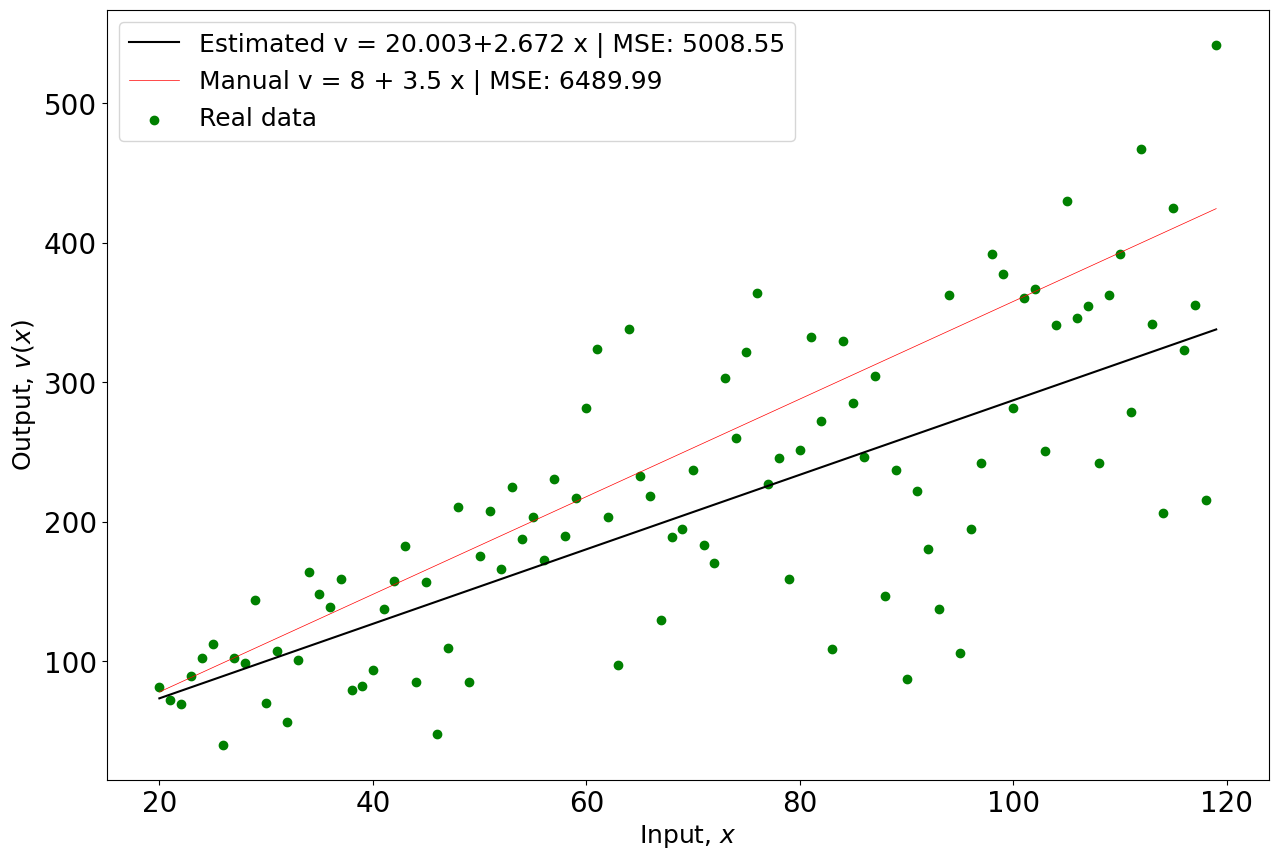

In [24]:
plt.figure(figsize=(15, 10))

plt.xlabel('Input, $x$', fontsize=label_font_size)
plt.ylabel('Output, $v(x)$', fontsize=label_font_size)

v_estimate = b + a * points
plt.plot(points, v_estimate, label=f"Estimated v = {round(b, 3)}+{round(a, 3)} x | MSE: {mse(v, v_estimate)}", color='k', lw=1.5);
plt.plot(points, v_estimate_one, label=f"Manual v = 8 + 3.5 x | MSE: {mse(v, v_estimate_one)}", color='r', lw=0.5);
#plt.plot(points, y_real, label='real', color='r', lw=0.5);
plt.scatter(points, v, label='Real data', color='g')

plt.legend(fontsize=legend_font_size);

It's clear that given only the half of the observation we do much worse. But can we do something about?

# 3. Regularization: LASSO and Ridge regressions 

# Ridge regression 

We try to improve our estimate by removing the effect of "very noisy" samples.
One of the ways to do so is to penalize big values for our estimates of $a$ and $b$ or the vector $\theta$ in general.

$$
MSE(\mathbf{y}, X^T\mathbf{\theta}) + \lambda\|\mathbf{\theta}\|_2^2=  \|\mathbf{y} - X^T\mathbf{\theta}\|^2_2 + \lambda\|\mathbf{\theta}\|^2_2
$$

It's possible to solve it using gradient descend,but we will use an analytical solution for this case again:

$$
\mathbf{\theta}^*_{\text{reg}} = (X^T X + \lambda I_p)^{-1}X^T \mathbf{y},
$$
where $I_p$ is a diagonal matrix consisting of ones, and $\lambda$ is a regularisation coefficient.


# Lasso regression 

$$
MSE(\mathbf{y}, X^T\mathbf{\theta}) + \lambda\|\mathbf{\theta}\|_2^2=  \|\mathbf{y} - X^T\mathbf{\theta}\|^2_2 + \lambda\|\mathbf{\theta}\|_1.
$$

The main difference here is that LASSO regression has $l_1$ norm instead of $l_2$ norm for the regularisation term. LASSO solution has no analytical form, but can be found via a gradient descent.

Below we will work through some examples with Ridge regression. Note, that the difference may seem small, but leads to quite different results.

In [ ]:
# AGAIN YOUR TASK HERE IS TO COMPUTE THETA AS IN EQUATION ABOVE FOR THETA

def compute_theta_regularized(X, y, lambda_value):
    # X is a vector of values
    # y is a vector of values
    # lambda_value is a regularization coefficient

    # EXPAND OUR X WITH ONES FOR BIAS TERM
    x_with_ones = np.ones(shape = (X.shape[0], 2))
    x_with_ones[:, 1] = X
    
    n_features = x_with_ones.shape[1]
    lambda_on_diagonal_matrix = lambda_value * np.eye(n_features) 

    # COMPUTE THETA TIPS:
    # np.linalg.inv(matrix) - use to compute inverse of a matrix
    # np.dot(matrix_one, matrix_two) - use for matrix multiplocation

    # theta = 
    return theta


In [25]:
# SOLUTION

def compute_theta_regularized(X, y, lambda_value):
    # EXPAND OUR X WITH ONES FOR BIAS TERM
    x_with_ones = np.ones(shape = (X.shape[0], 2))
    x_with_ones[:, 1] = X
    
    n_features = x_with_ones.shape[1]
    theta =  np.linalg.inv(x_with_ones.T.dot(x_with_ones) + lambda_value * np.eye(n_features)).dot(x_with_ones.T).dot(y)
    return theta

Here $\lambda$ is our hyperparameter which we usually need to optimize, and value of $\lambda = 0$ should give us the same solution as one we had before - let's do it as a sanity check.

In [26]:

training_points_number = 50

training_points = np.random.choice(points.shape[0], training_points_number,  replace=False)

print(compute_theta_regularized(points[training_points], v[training_points], 0))

[32.69991785  2.44829559]


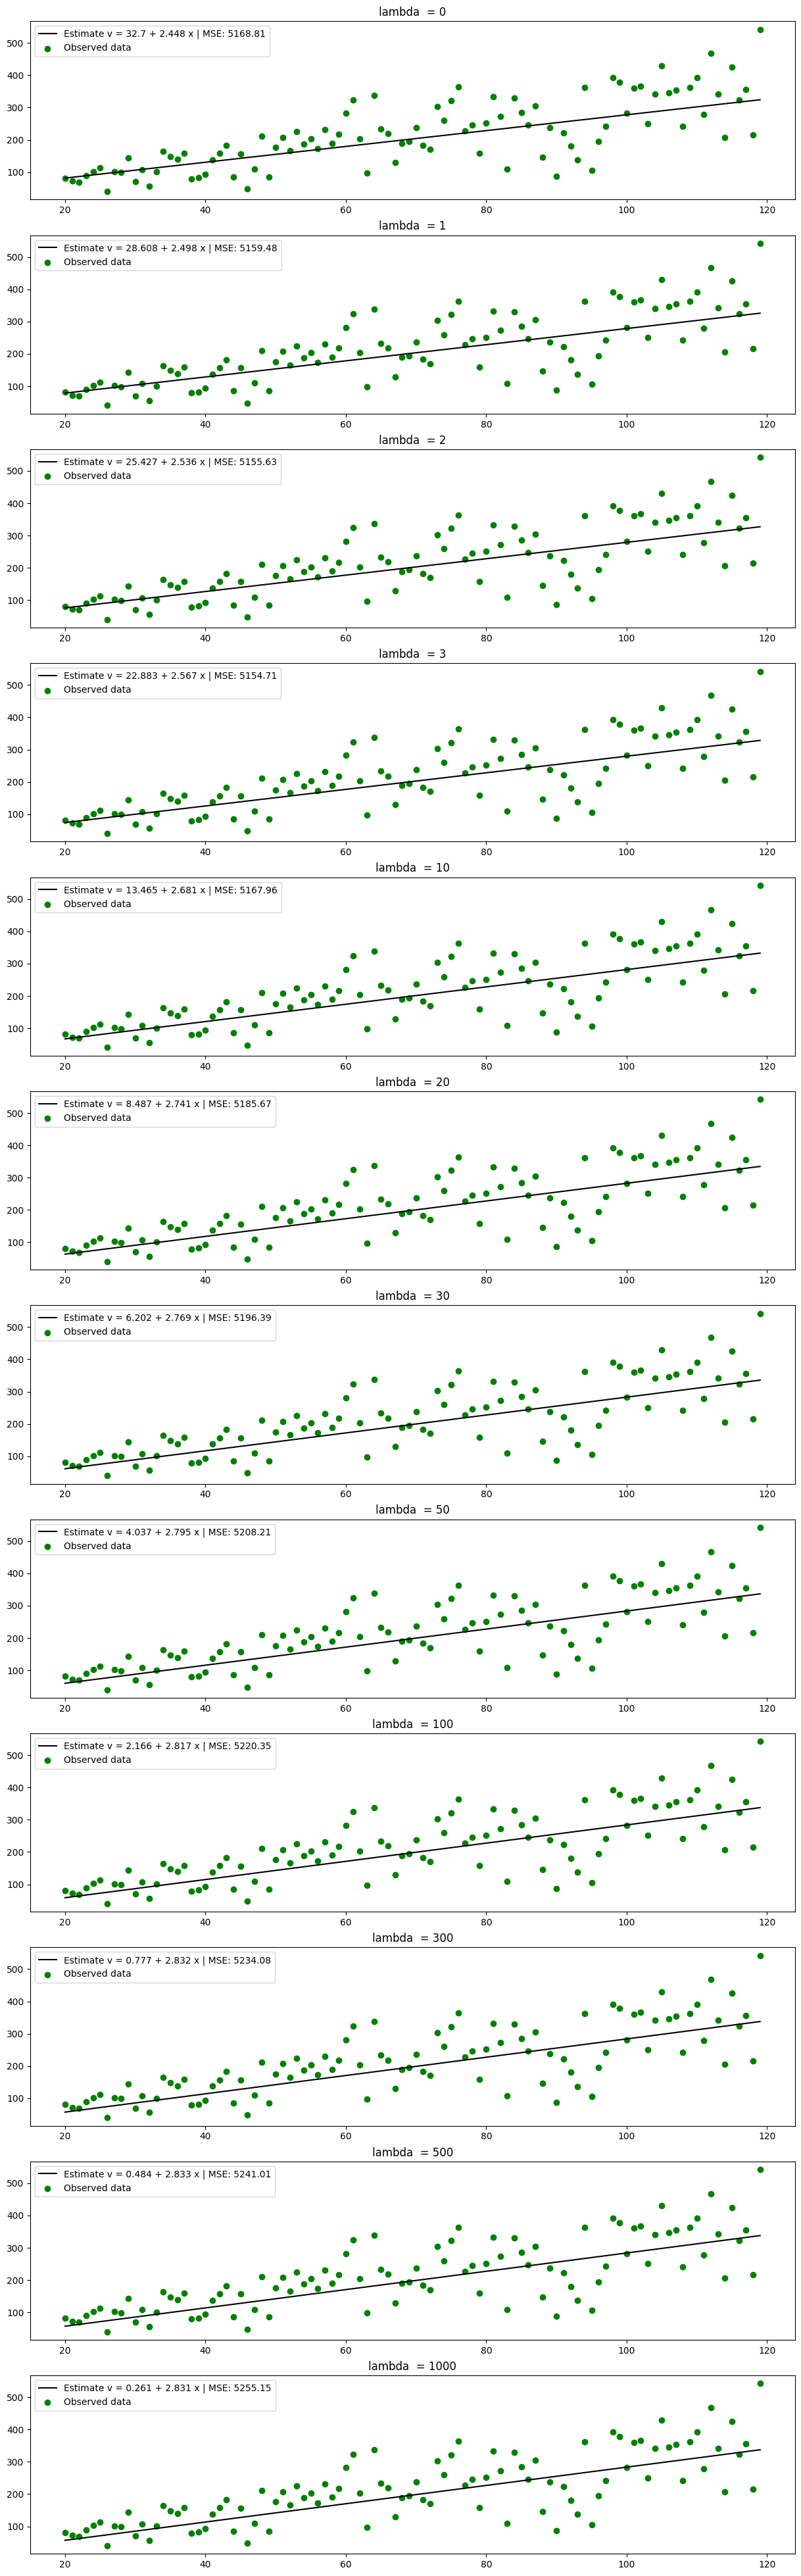

In [27]:
font = {'size'   : 10}
plt.rc('font', **font)

f, ax = plt.subplots(12, 1, figsize=(15, 50))

lambdas = [0, 1, 2, 3, 10, 20, 30, 50, 100, 300, 500, 1000]


for i in range(len(lambdas)):
    b, a  = list(compute_theta_regularized(points[training_points], 
                                           v[training_points], lambdas[i]))
    v_estimate = b + a * points
    ax[i].plot(points, v_estimate, label=f"Estimate v = {round(b, 3)} + {round(a, 3)} x | MSE: {mse(v, v_estimate)}", color='k', lw=1.5);
    #plt.plot(t, y_real, label='real', color='r', lw=0.5);
    ax[i].scatter(points, v, label='Observed data', color='g')
    ax[i].set_title(f'lambda  = {lambdas[i]}');
    ax[i].legend();

**Lasso Regression**

To show the difference between Lasso and Ridge we will do the same estimations.
We use LASSO regression from sklearn. For model training we use even fewer ponits: only 15. So, our results will be different from the previous.

/home/diff7/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/home/diff7/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/diff7/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.450e+04, tolerance: 1.242e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max_iter

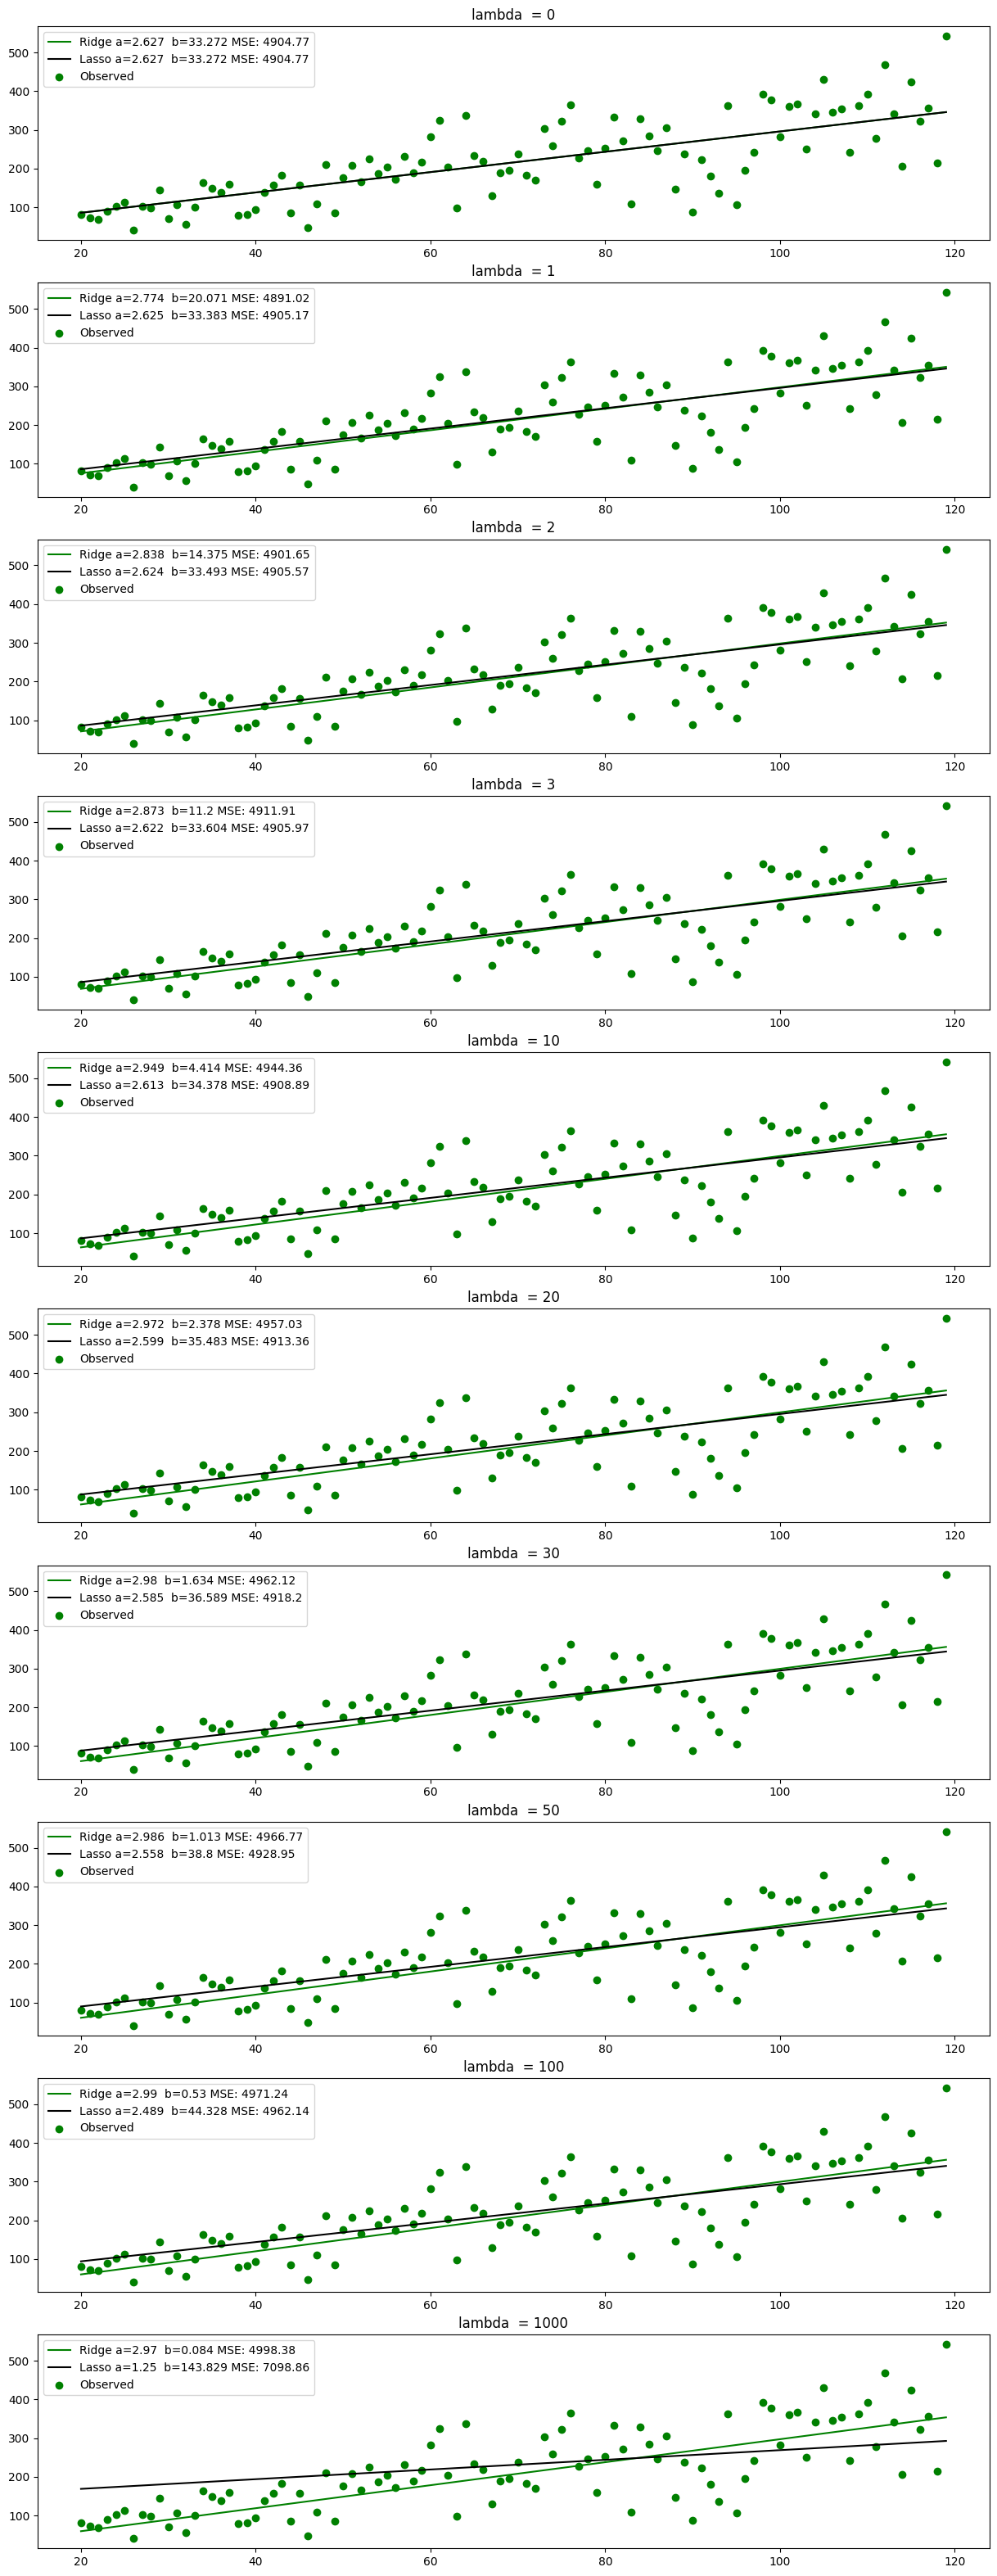

In [28]:
font = {'size'   : 10}
plt.rc('font', **font)

f, ax = plt.subplots(10, 1, figsize=(15, 40))

from sklearn.linear_model import Lasso

lambdas = [0, 1, 2, 3, 10, 20, 30, 50, 100, 1000]

training_points_number = 15

training_points = np.random.choice(points.shape[0], training_points_number,  replace=False)

for i in range(len(lambdas)):
    b, a  = list(compute_theta_regularized(points[training_points], 
                                           v[training_points], lambdas[i]))
    lasso = Lasso(alpha=lambdas[i],  max_iter=100, tol=0.001)
    
    lasso.fit(points[training_points].reshape(-1, 1), v[training_points])
    v_lasso = lasso.predict(points.reshape(-1, 1))
    v_estimate = b + a * points
    ax[i].plot(points, v_estimate, label=f"Ridge a={round(a, 3)}  b={round(b, 3)} MSE: {mse(v, v_estimate)}", color='g', lw=1.5);
    ax[i].plot(points, v_lasso, label=f"Lasso a={round(float(lasso.coef_), 3)}  b={round(float(lasso.intercept_), 3)} MSE: {mse(v_lasso, v)}", 
               color='k', lw=1.5);
    ax[i].scatter(points, v, label='Observed', color='g')
    ax[i].set_title(f'lambda  = {lambdas[i]}');
    ax[i].legend();

We see that both give different results based on $\lambda$ values, and it is difficult to say which one is better. However, we can notice that with hight lambda values, Lasso tends to zero our coefficient while Ridge reduces the slope value - our coefficient but does not zero it.

We just used regularization term and improved our estimates for $a$, the average value we have got is around 3.3, which is quite close for our initial value. Even though our estimate for $v_0$ is not good enough due to a lot of initial noise, it is still a good result. 


Well done!

# 3. Kernels

What is our initial function was more complex than $ v = v(x) = v_0 + a x$? Could we still use the same tools and get good results? Let's try for the following equation: 
$$ D(x) = \cos(\sqrt{g / l} \cdot x) + \epsilon$$ 

This time we will have noisy $$ \epsilon =  \mathcal{N}(0, 0.5)$$

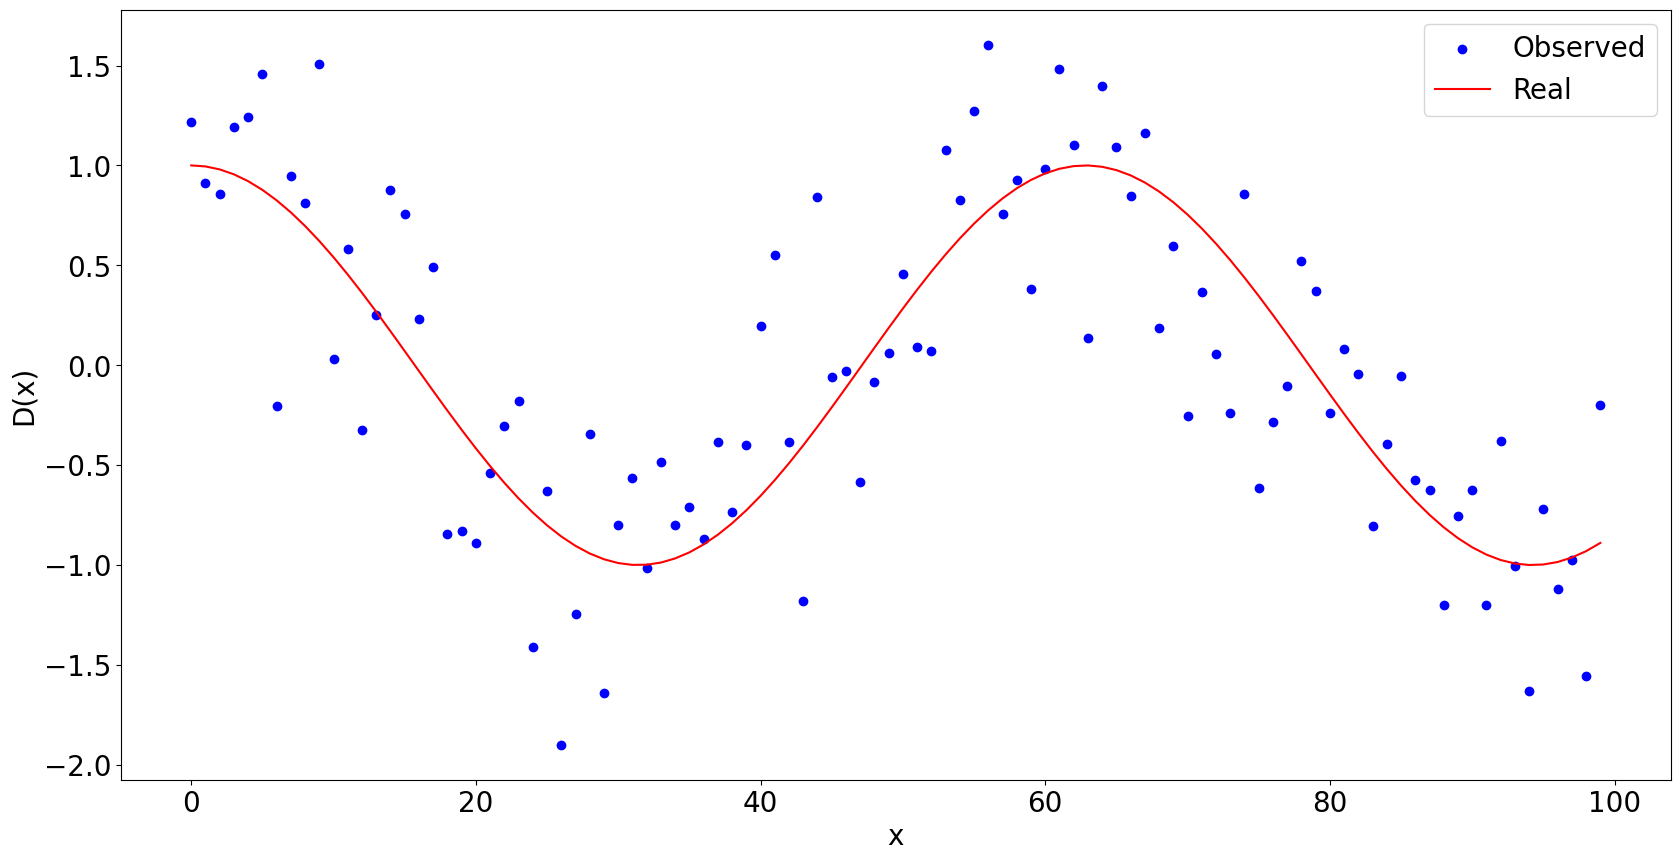

In [29]:
np.random.seed(4242)

font = {'size'   : 20}
plt.rc('font', **font)

def D(g, l, t):
    return np.cos(np.sqrt(g / l) * t)
    
points = np.arange(0, 100)

l_real = 100
g_real = 1

d_real = D(g_real, l_real, points)

eps = np.random.normal(0, scale=0.5, size=points.shape)

d = d_real + eps
    
plt.figure(figsize=(20, 10))

plt.scatter(points, d, label='Observed', color='b')
plt.plot(points, d_real, label='Real', color='r')
plt.xlabel('x')
plt.ylabel('D(x)')
plt.legend();

In [30]:
print(compute_theta_regularized(points, d, 0))
b, a = list(compute_theta_regularized(points, d, 0))

[ 0.31888818 -0.00689341]


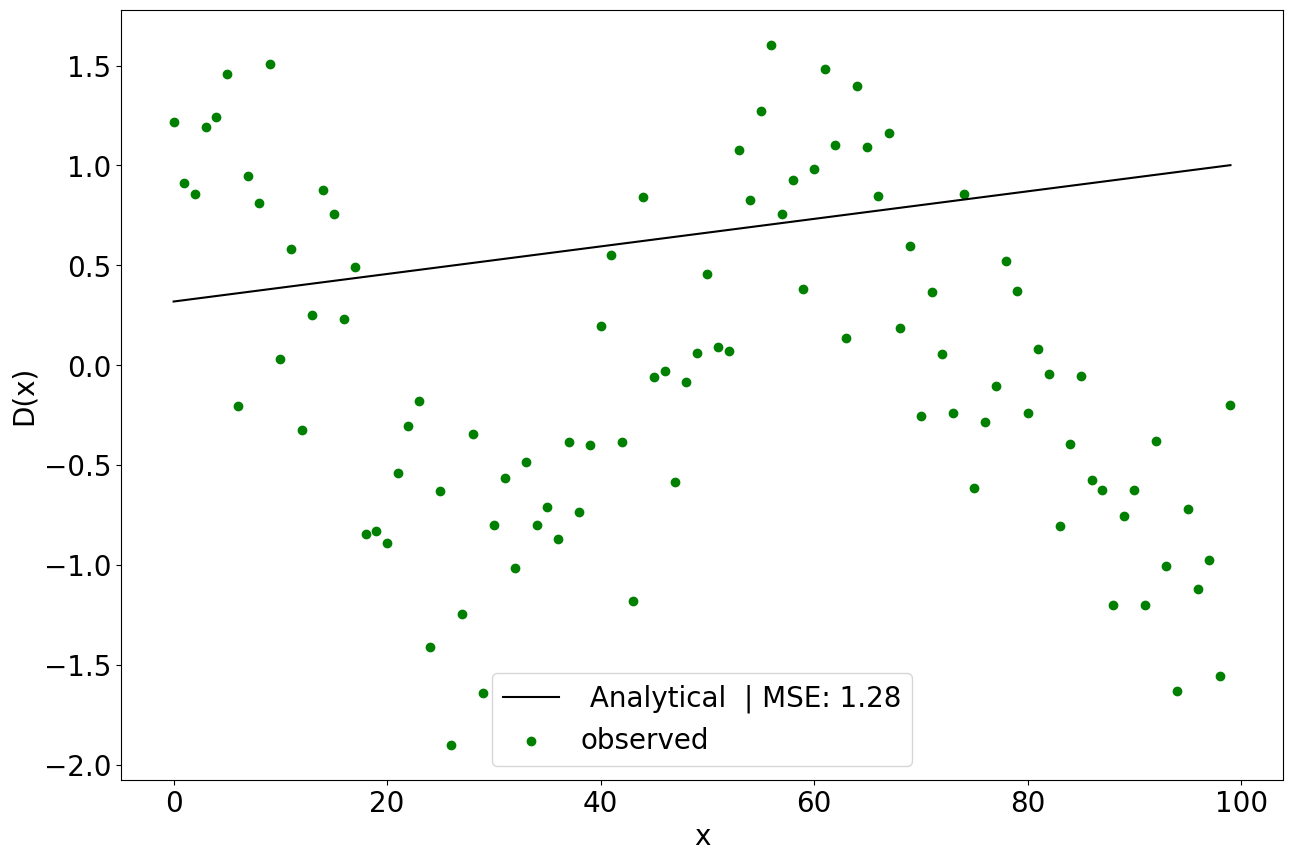

In [31]:
plt.figure(figsize=(15, 10))
plt.ylabel('D(x)')
plt.xlabel('x')
d_estimate = b - a * points
plt.plot(points[:100], d_estimate[:100], label=f" Analytical  | MSE: {mse(d, d_estimate)}", 
         color='k', lw=1.5);
plt.scatter(points, d, label='observed', color='g')
plt.legend();

Well, it's clearly not what we want here and we need somehing more complicated than linear assumption

The easiest way to solve it is to add polynomial features to our observations which create non-linear dependencies, let's try it. Now we need to create polynomial features and find coefficients for each one. To compute our estimates or model predictions, we will use the following equation:


$$\hat{f}(x) = a_1 x^1 + a_2 x^2 + \ldots a_n x^n + b = \theta^{T} X $$

In [32]:
# this functions returns weights together with new polynomial features

def make_polynomial_features(x_train, p):
    poly = np.zeros(shape = (len(x_train), p + 1))
    poly[:, 0] = 1
    for i in range(1, p + 1):
        poly[:, i] = np.power(x_train, i).reshape((len(x_train),))
    return poly

def ridge_polynomial_regression(x_poly, y, lambda_value):    
    theta = np.linalg.pinv((x_poly.T.dot(x_poly) + lambda_value * np.eye(x_poly.shape[1]))).dot(x_poly.T).dot(y)
    return theta

In [33]:
x_poly = make_polynomial_features(points, p=3)
theta = ridge_polynomial_regression(x_poly, d, 0)

In [34]:
print(theta)

[ 1.51487581e+00 -1.65814286e-01  4.18460014e-03 -2.88523156e-05]


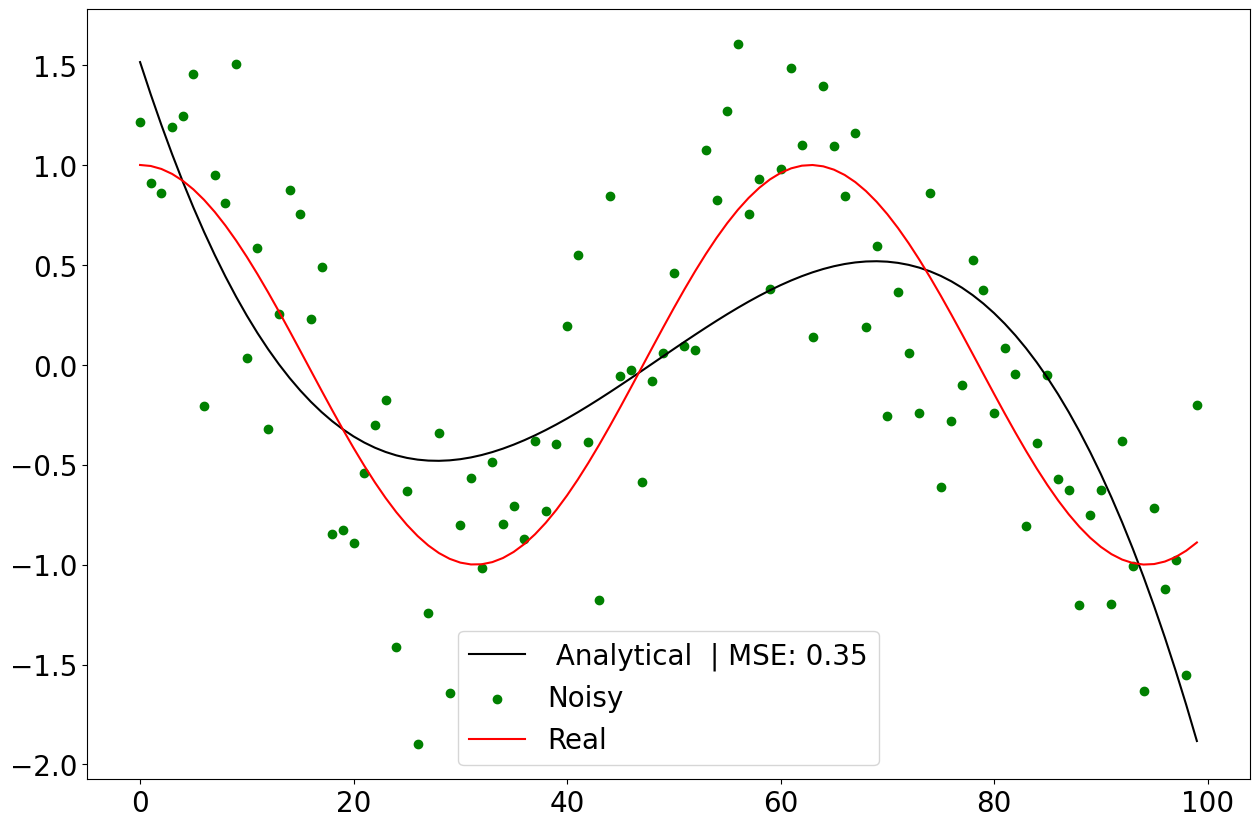

In [35]:
plt.figure(figsize=(15, 10))

y_estimate_p = x_poly.dot(theta)
plt.plot(points, y_estimate_p, label=f" Analytical  | MSE: {mse(d, y_estimate_p)}", color='k', lw=1.5);
#plt.plot(points, y_real, label='real', color='r', lw=0.5);
plt.scatter(points, d, label='Noisy', color='g')
plt.plot(points, d_real, label='Real', color='r')
plt.legend();

We created polynomial features on the base on our data. Our assumption was that the highest degree of 3 provides the best results. But what if our assumption is wrong, and our data samples have no polynomial relationship? 

Well, we can use other "Kernels" to account for it.

One of the common kernels is RBF (Radial Basis Function) kernel, let's see how it works in practice.
https://en.wikipedia.org/wiki/Radial_basis_function_kernel

We skip the deriviation of the kernel method for now except a few important equations:
$$
\hat{f} = \theta^T\phi(\mathbf{x})
$$

$\phi(x)$ is our non linear mapping function.

$$
\theta^T \phi(\mathbf{x}) = \mathbf{y} (\phi \phi^T + \lambda I)^{-1} \phi^T \phi(\mathbf{x}),
$$

$$
\theta^T\phi(x) = \mathbf{y} (K + \lambda I)^{-1} k_k,
$$

$$
\hat{f} = \mathbf{y} (K + \lambda I)^{-1} k_k,
$$

$K$ is our kernel function.

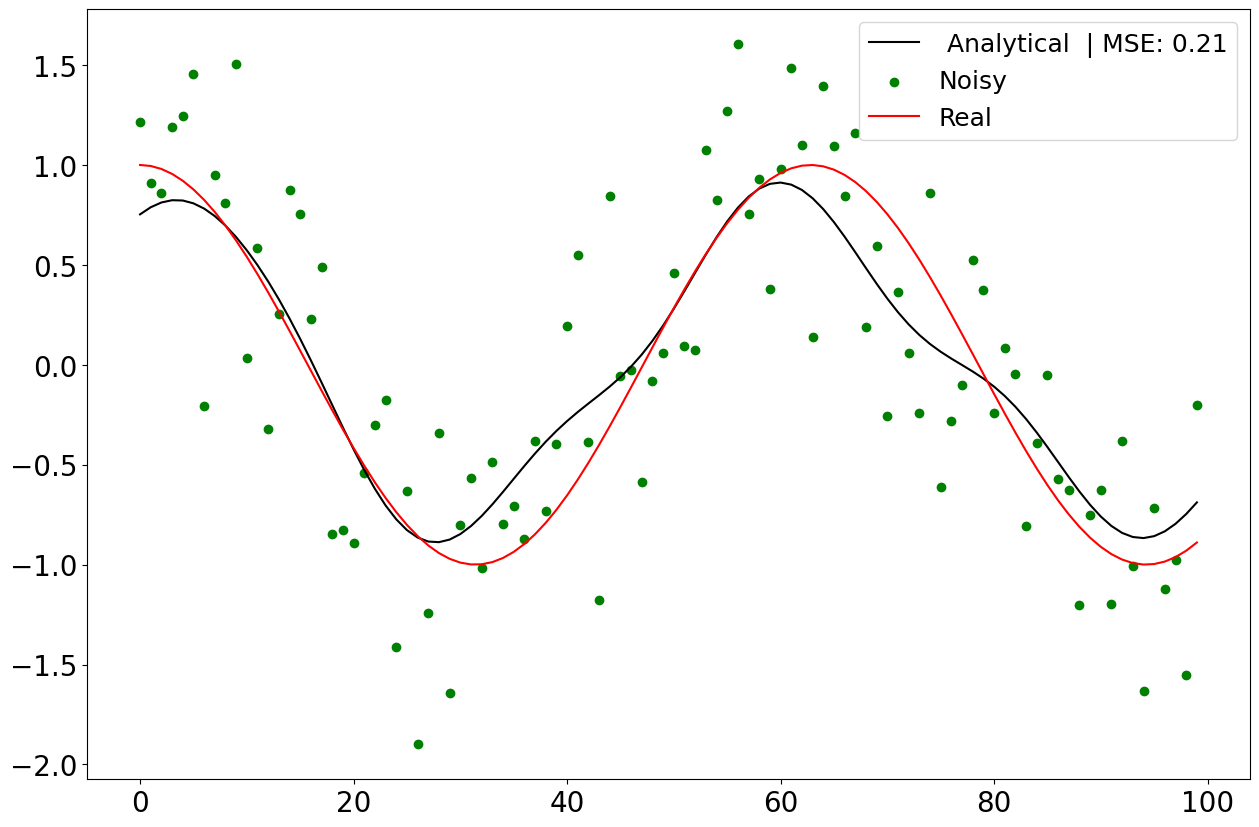

In [36]:
from scipy.spatial.distance import pdist, squareform

def rbf_kernel(X, gamma=1):
    '''Evaluates the RBF kernel for all pairs of rows in X'''
    return np.exp(-gamma * squareform(pdist(X.T, 'sqeuclidean')));

def kernel_ridge_solution(X, y, l=1, gamma=1):
    """ Given a kernel, compute y_hat"""
    x_with_ones = np.ones(shape = (X.shape[0], 2))
    x_with_ones[:, 1] = X
    K = rbf_kernel(x_with_ones.T, gamma)
    W = K.dot(np.linalg.inv(K + l * np.eye(x_with_ones.shape[0])))
    yhat = W.dot(y)
    return yhat, K, W
 
yhat, K, H = kernel_ridge_solution(points, d, l=2, gamma=0.01)

plt.figure(figsize=(15, 10))
plt.plot(points, yhat, label=f" Analytical  | MSE: {mse(d, yhat)}", color='k', lw=1.5);
#plt.plot(points, y_real, label='real', color='r', lw=0.5);
plt.scatter(points, d, label='Noisy', color='g')
plt.plot(points, d_real, label='Real', color='r')
plt.legend(fontsize=legend_font_size);

It's different from true observations, but quite good, and now we can model a rather general class of nonlinear dependencies.

### An example of overfitting

Kernels and Addition of polynomial features help to approximate our true nonlinear function. 

Would it be a good idea to add more polynomial features, and when should we stop?

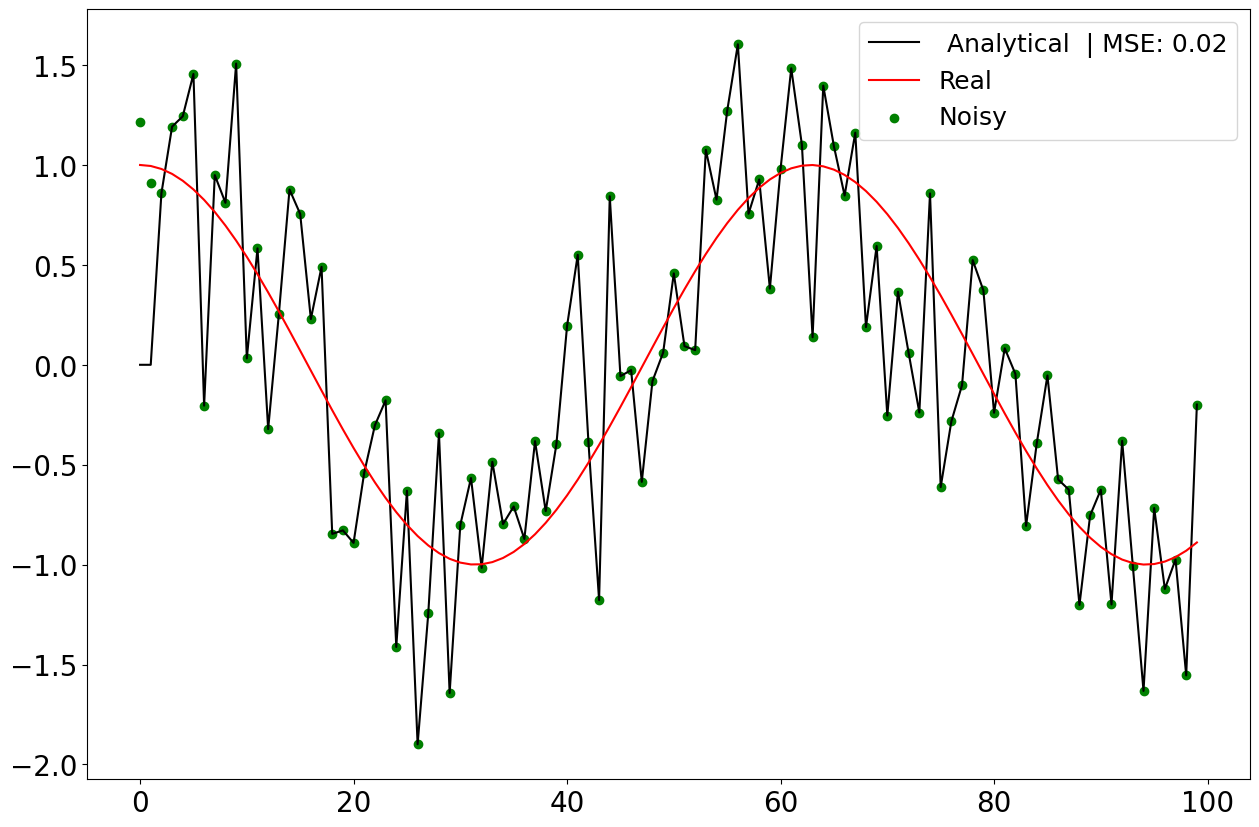

In [37]:
x_poly = make_polynomial_features(points, p=120)
theta = ridge_polynomial_regression(x_poly, d, 0)

plt.figure(figsize=(15, 10))
y_estimate_p = x_poly.dot(theta)
plt.plot(points, y_estimate_p, label=f" Analytical  | MSE: {mse(d, y_estimate_p)}", color='k', lw=1.5);
#plt.plot(points, y_real, label='real', color='r', lw=0.5);
plt.plot(points, d_real, label='Real', color='r');
plt.scatter(points, d, label='Noisy', color='g')
plt.legend(fontsize=legend_font_size);

## Well, we see that order of 120 we have a very low error. 
## But did we recover our inital dependency?
## How to choose the best order of polynomial for generated features?
<hr>

### To answer these questions, we need to consider real world scenarios.
### 1. Usually, in real life problems we deal with multidimensional problems - a lot of features. It means we can't plot them and see, if we have a good fit or not.
### 2. Also, often we have some training data and we need to know, how well we will predict at unseen data.


### One way to solve this problem is 
1. Split our data in three parts
- train
- validation 
- test

2. Find optimal $\theta$ using the training part
3. Find optimal order of polynimial features with validation by minimizing MSE on the validation part
4. Check MSE values on the test part - we assume that the error on test shows, how well we predict/esimate on unseen data. 

In [38]:
# spit our data in three parts
train_points, train_d = points[0::3], d[0::3]
val_points, val_d = points[1::3], d[1::3]
test_points, test_d = points[2::3], d[2::3]

In [39]:
test_points

array([ 2,  5,  8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50,
       53, 56, 59, 62, 65, 68, 71, 74, 77, 80, 83, 86, 89, 92, 95, 98])

In [40]:
val_points

array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49,
       52, 55, 58, 61, 64, 67, 70, 73, 76, 79, 82, 85, 88, 91, 94, 97])

In [41]:
train_points

array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48,
       51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99])

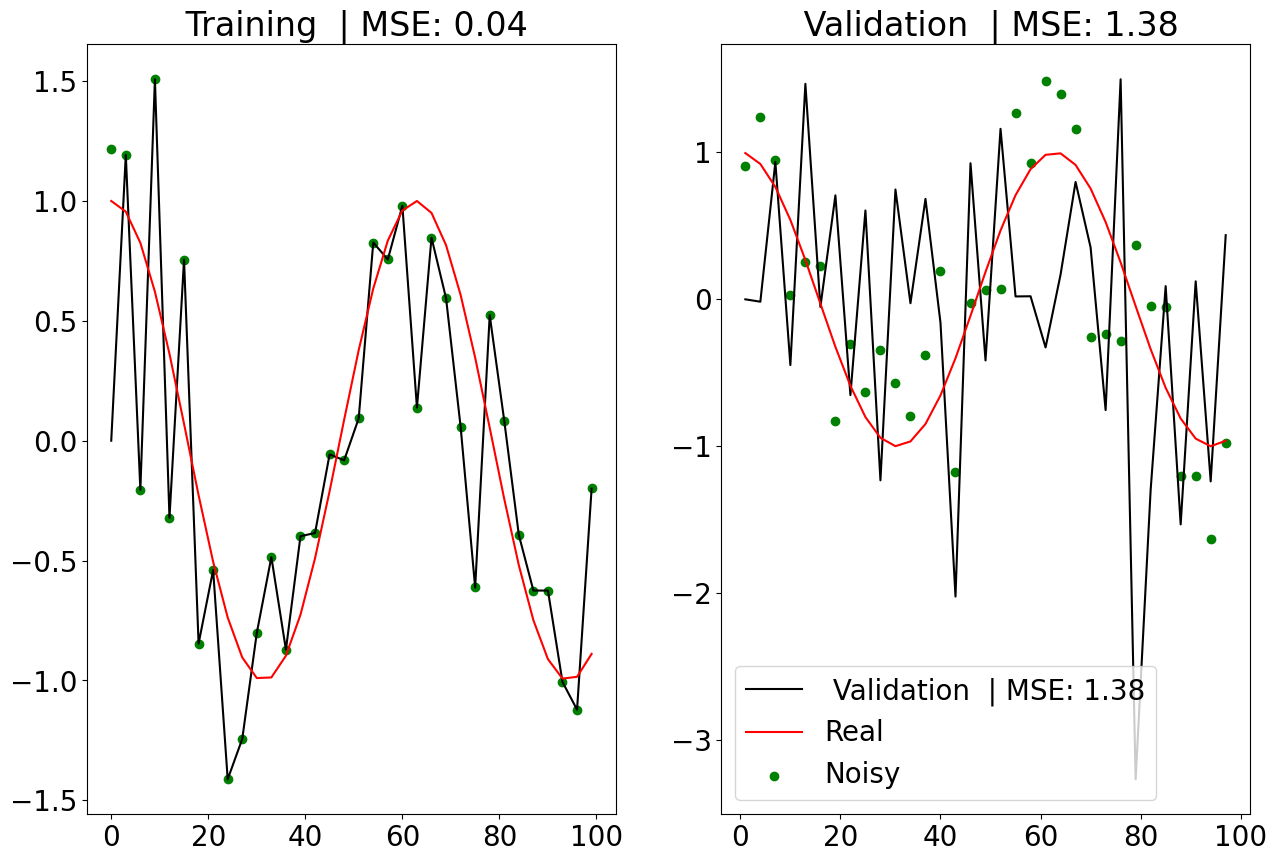

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))


x_train = make_polynomial_features(train_points, p=100)
theta = ridge_polynomial_regression(x_train, train_d, 0)

y_train = x_train.dot(theta)
ax[0].plot(train_points, y_train, label=f" Training  | MSE: {mse(y_train, train_d)}", color='k', lw=1.5);
ax[0].plot(points[0::3], d_real[0::3], label='Real', color='r');
ax[0].scatter(points[0::3], d[0::3], label='Noisy', color='g')
ax[0].set_title(f" Training  | MSE: {mse(y_train, train_d)}")

x_val = make_polynomial_features(val_points, p=100)
y_val = x_val.dot(theta)
ax[1].plot(val_points, y_val, label=f" Validation  | MSE: {mse(y_val, val_d)}", color='k', lw=1.5);
ax[1].plot(points[1::3], d_real[1::3], label='Real', color='r');
ax[1].scatter(points[1::3], d[1::3], label='Noisy', color='g')
ax[1].set_title(f" Validation  | MSE: {mse(y_val, val_d)}")

plt.legend();

### The effect we observe here is overfitting. 

### Your assignemnt now is to find such order of polynomial feauters that our error on validation test is minimal. 
### Note, you can use train data to estimate values for $\theta$.

In [1]:
# # ASSIGNMENT
# # FIND THE P - order of poylinomials which minimiezes error on validation part of dataset

print(f' Best  p {best_p}, best MSE on validation {best_mse}')

In [43]:
# SOLUTION

best_mse = 10000
best_p = 0

for p in range(1, 100):
    x_train = make_polynomial_features(train_points, p=p)
    theta = ridge_polynomial_regression(x_train, train_d, 0)
    y_train = x_train.dot(theta)
    x_val = make_polynomial_features(val_points, p=p)
    y_val = x_val.dot(theta)
    val_mse = mse(y_val, val_d)
    if best_mse > val_mse:
        best_mse = val_mse
        best_p = p        
print(f' Best  p {best_p}, best MSE on validation {best_mse}')


 Best  p 3, best MSE on validation 0.35


Text(0.5, 1.0, ' Test  | MSE: 0.66')

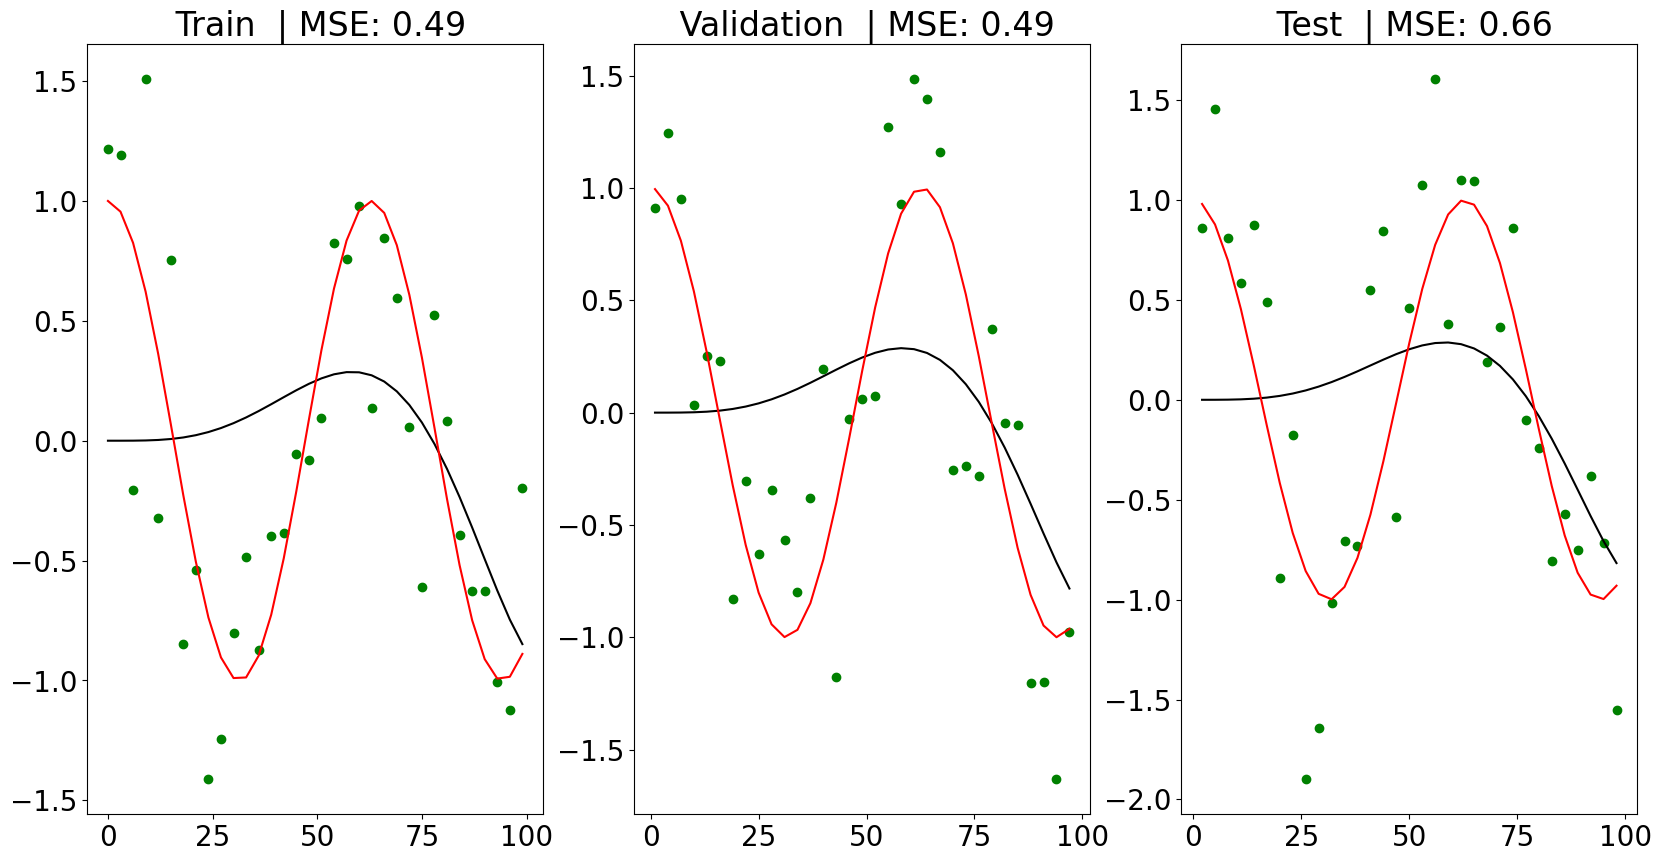

In [45]:
P = 6


fig, ax = plt.subplots(1, 3, figsize=(20,10))


x_train = make_polynomial_features(train_points, P)
theta = ridge_polynomial_regression(x_train, train_d, 0)

y_train = x_train.dot(theta)
ax[0].plot(train_points, y_train, label=f" Train  | MSE: {mse(y_train, train_d)}", color='k', lw=1.5);
ax[0].plot(points[0::3], d_real[0::3], label='Real', color='r');
ax[0].scatter(points[0::3], d[0::3], label='Noisy', color='g')
ax[0].set_title(f" Train  | MSE: {mse(y_train, train_d)}")

x_val = make_polynomial_features(val_points, P)
y_val = x_val.dot(theta)
ax[1].plot(val_points, y_val, label=f" Validation  | MSE: {mse(y_val, val_d)}", color='k', lw=1.5);
ax[1].plot(points[1::3], d_real[1::3], label='Real', color='r');
ax[1].scatter(points[1::3], d[1::3], label='Noisy', color='g')
ax[1].set_title(f" Validation  | MSE: {mse(y_val, val_d)}")

x_test = make_polynomial_features(test_points, P)
y_test = x_test.dot(theta)
ax[2].plot(test_points, y_test, label=f" Validation  | MSE: {mse(y_test, test_d)}", color='k', lw=1.5);
ax[2].plot(points[2::3], d_real[2::3], label='Real', color='r');
ax[2].scatter(points[2::3], d[2::3], label='Noisy', color='g')
ax[2].set_title(f" Test  | MSE: {mse(y_test, test_d)}")

1. How can you explain this effect?
2. Why do we need to split our data in three parts? 
3. What our MSE error will be likelly on unseen data from the same distribution?
